## RBIF 110 Cheminformatics
### Sample Virtual Screening Workflow
By Jeff Warrington


In [ ]:
#First we will mount our google drive to the instance and copy the pymol license (which in my case is in the Colab directory)
import os
from google.colab import drive
#drive.mount("/content/drive")
#%shell cp /content/drive/MyDrive/Pymol/pymol-edu-license-2023.lic .
#os.rename("/content/pymol-edu-license-2023.lic", "license.lic")


Mounted at /content/drive


In [ ]:
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static

--2024-03-18 22:09:49--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 172.64.150.145, 104.18.37.111, 2606:4700:4400::6812:256f, ...
Connecting to sourceforge.net (sourceforge.net)|172.64.150.145|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABl-LutGtcZTbV8iPhpiItFDvqzu8kaWfPopkl52AZo1p2zQ_Ai2lPTX7sARzakoStSZfsY60Iijx0dF5VucjcYyIuCyw%3D%3D&use_mirror=nchc&r= [following]
--2024-03-18 22:09:49--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABl-LutGtcZTbV8iPhpiItFDvqzu8kaWfPopkl52AZo1p2zQ_Ai2lPTX7sARzakoStSZfsY60Iijx0dF5VucjcYyIuCyw%3D%3D&use_mirror=nchc&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: 

In [ ]:
!python --version

Python 3.10.12


In [ ]:
#This code should install Pymol and other packages we need with a nice progress bar. Execution time varies but can take 5-10 mins
#The instance is likely to reconnect and you will get a message that the instance has crashed
#The instance was rebooting to install condacolab


from IPython.utils import io
import tqdm.notebook
import os
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:

        !pip install -q condacolab
        import condacolab
        condacolab.install()
        pbar.update(10)

        import sys
        sys.path.append('/usr/local/lib/python3.7/site-packages/')
        pbar.update(10)

        # Install PyMOL
        %shell mamba install -c schrodinger pymol-bundle --yes
        pbar.update(10)
        #Install mols2grid we will use later
        %shell mamba install -c conda-forge mols2grid --yes
        pbar.update(10)
        %shell mamba install rdkit --yes
        pbar.update(10)
        %shell mamba install py3Dmol --yes
        pbar.update(100)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#import some cheminformatics packages and data processing packages
import rdkit
from rdkit import Chem

import py3Dmol
import mols2grid

import numpy as np
import pandas as pd

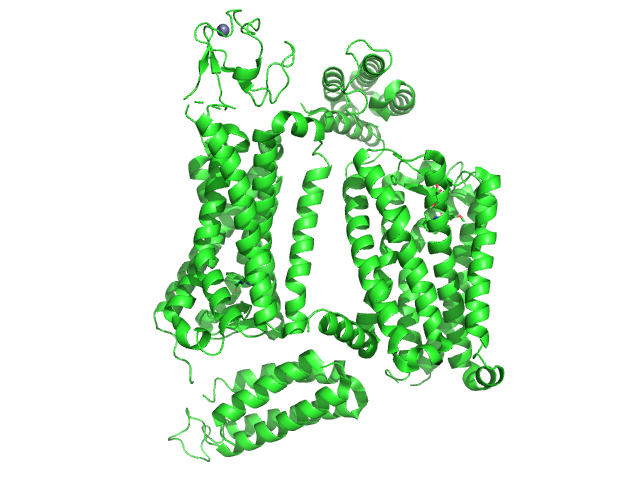

In [ ]:
#Test to make sure pymol is working lets download melatonin receptor and display
from pymol import cmd
from IPython.display import Image
cmd.reinitialize()
cmd.fetch("6me7")
cmd.orient("6me7")
cmd.rotate("z","270")
cmd.png("image.png") #In order to display in our python notebook we need to make a temp image called image.png
Image(filename = "image.png", unconfined=True)

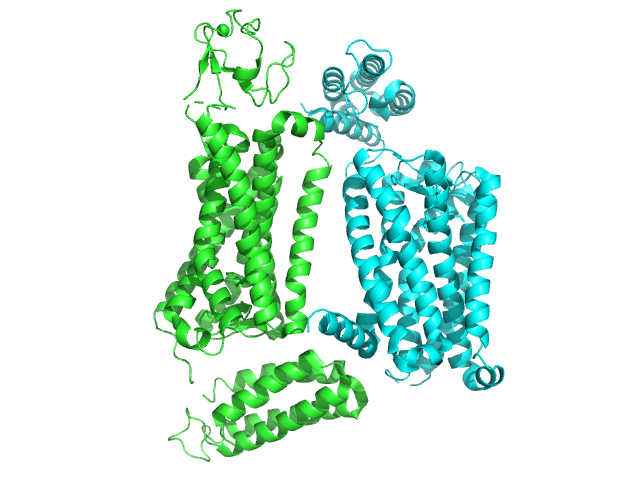

In [ ]:
#There are likely multiple chains here, so we need to check that (CBC = Color By Chain)
cmd.util.cbc()
cmd.png("image.png")
Image(filename = "image.png", unconfined=True)

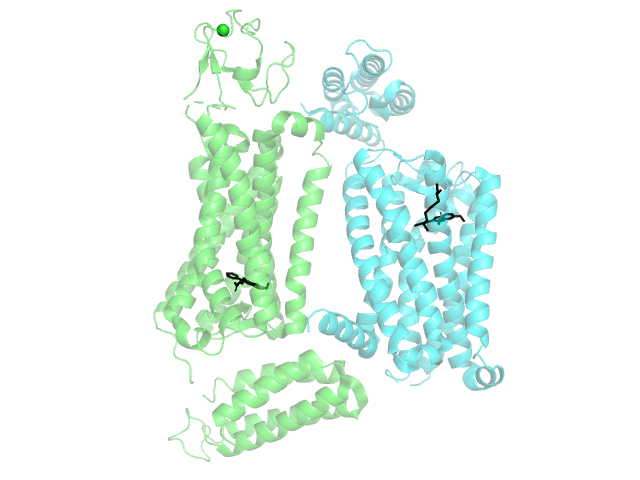

In [ ]:
cmd.color("black","organic")
cmd.set("cartoon_transparency",0.5)
cmd.png("image.png")
Image(filename = "image.png", unconfined=True)

#### **Observation:** By coloring the organic structures black, and reducing the cartoon transparency, we can see that there are two replicate chains in the crystal structure, but we will only need one for the docking experiment.

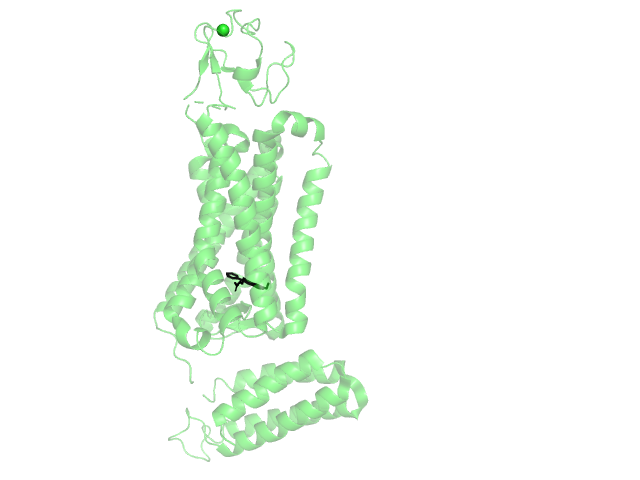

In [ ]:
#Ok, for the docking experiment we only want one of the two receptors in the unit cell, so lets delete Chain B
cmd.remove("chain B")
cmd.png("image.png")
Image(filename = "image.png", unconfined=True)

In [ ]:
#Now we need to split the above into a ligand and a receptor file
cmd.select("6ME7-ligand", "resn JEY") #Create a selection called 6ME7-ligand from the ligand
cmd.select("6ME7-receptor", "6ME7 and not 6ME7-ligand")  #Select all that is not the ligand, and make that the protein
cmd.save("6ME7-ligand.pdb", "6ME7-ligand")
cmd.save("6ME7-receptor.pdb", "6ME7-receptor")

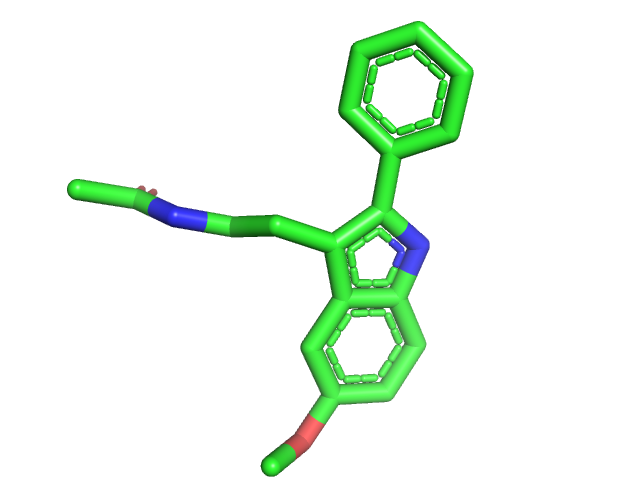

In [ ]:
#Now lets look at the individual files -first the ligand
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("6ME7-ligand.pdb")
cmd.png("ligand.png")
Image(filename = "ligand.png", unconfined=True)

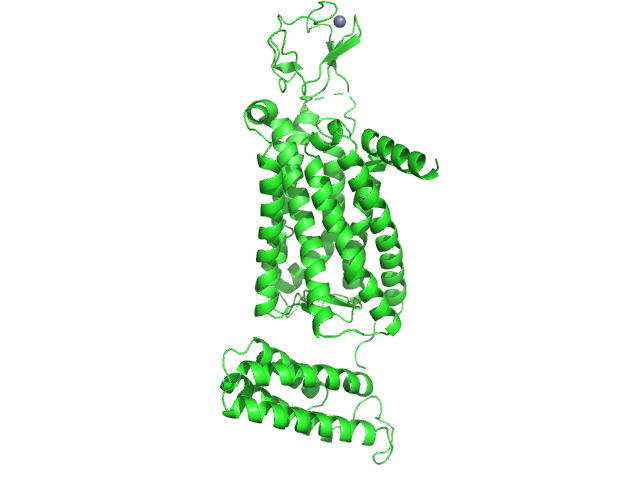

In [ ]:
#Now the receptor
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("6ME7-receptor.pdb")
cmd.orient("6ME7-receptor")
cmd.rotate("z","270")
cmd.png("receptor.png")
Image(filename = "receptor.png", unconfined=True)

In [ ]:
#Lets look at the smina program - you can get a list of possible commands and switches by just running the program with no arguments
!chmod u+x smina.static
!./smina.static

Missing receptor.

Correct usage:

Input:
  -r [ --receptor ] arg         rigid part of the receptor (PDBQT)
  --flex arg                    flexible side chains, if any (PDBQT)
  -l [ --ligand ] arg           ligand(s)
  --flexres arg                 flexible side chains specified by comma 
                                separated list of chain:resid or 
                                chain:resid:icode
  --flexdist_ligand arg         Ligand to use for flexdist
  --flexdist arg                set all side chains within specified distance 
                                to flexdist_ligand to flexible

Search space (required):
  --center_x arg                X coordinate of the center
  --center_y arg                Y coordinate of the center
  --center_z arg                Z coordinate of the center
  --size_x arg                  size in the X dimension (Angstroms)
  --size_y arg                  size in the Y dimension (Angstroms)
  --size_z arg                  size in the Z dimen

Figure(120x120)


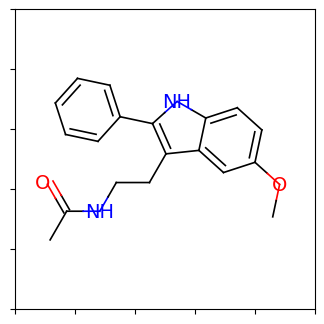

In [ ]:
#So now we need to make a new file, that has a "pure" unbiased version of the ligand - so lets create it directly from SMILES
#We can get the ligand information here: https://www.rcsb.org/ligand/JEY
# CC(=O)NCCc1c2cc(ccc2[nH]c1c3ccccc3)OC
from rdkit import Chem
from rdkit.Chem import Draw

size=(120,120)

lig = Chem.MolFromSmiles("CC(=O)NCCc1c2cc(ccc2[nH]c1c3ccccc3)OC")
print(Draw.MolToMPL(lig, size=size))


#### This is a 2D structure without 3D coordinates. SMINA needs a 3D structure - we can only get that by minimizing to the nearest energy minima. Thankfully RDKit has a minimizer

Figure(120x120)


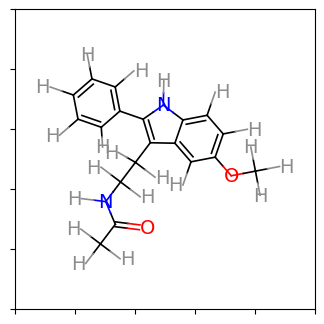

In [ ]:
lig = Chem.AddHs(lig, addCoords=True) #We need to add hydrogens to the new ligand
print(Draw.MolToMPL(lig, size=size))

In [ ]:
#Now to minimize to a 3D structure using the AllChem Module
import py3Dmol
from rdkit.Chem import AllChem
AllChem.EmbedMolecule(lig)
AllChem.MMFFOptimizeMolecule(lig)


#Display the result using py3Dmol
mblock = Chem.MolToMolBlock(lig)

view = py3Dmol.view(data=mblock, style={"stick": {}, "sphere": {"scale": 0.3}})
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
#Allright now we have the molecule converted to 3D - sae it as a new sdf
file = Chem.SDWriter('newligand.sdf') #create the file
file.write(lig) #write the 3d ligand to the file


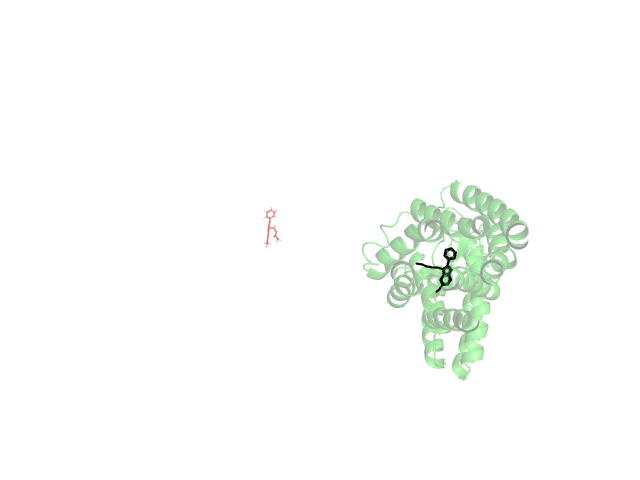

In [ ]:
#Lets check the new ligand - so the new ligand should be assigned random coordinates in space. If we load this new one into our previous PDB file, we will see it's somewhere random
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("6ME7-receptor.pdb")
cmd.load("6ME7-ligand.pdb")
cmd.color("black","6ME7-ligand")
cmd.load("newligand.sdf")
cmd.color("red","newligand")
cmd.set("cartoon_transparency",0.6)
cmd.select("ligands", "organic")
cmd.zoom("ligands")
#cmd.rotate("z","270")
cmd.png("receptor.png")
Image(filename = "receptor.png", unconfined=True)

#### **Observation** We can see the new minimized ligand is not even in the protein - so we need to use smina to "dock" the ligand back into the protein.

In [ ]:
#OK - so now we have the ligand and receptor in separate files, lets see if smina can redock the ligand into the receptor
#The autobox command tells smina to focus docking around the cognate ligand and create a "box"
!./smina.static -r  6ME7-receptor.pdb -l newligand.sdf --autobox_ligand 6ME7-ligand.pdb -o 6ME7-ligand-poses.sdf

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1533789458

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|-

In [ ]:
#Ok lets look at the sdf that was generated
from rdkit.Chem import PandasTools

dockedposes = PandasTools.LoadSDF("6ME7-ligand-poses.sdf")

,minimizedAffinity,ID,ROMol
0,-10.30477,,
1,-9.40611,,
2,-8.69042,,
3,-8.20459,,
4,-7.88146,,
5,-7.51157,,
6,-7.36403,,

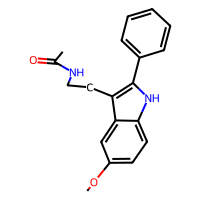
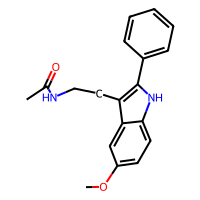
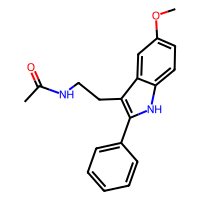
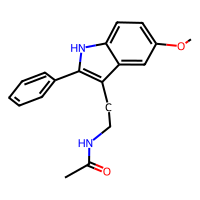
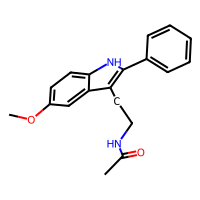
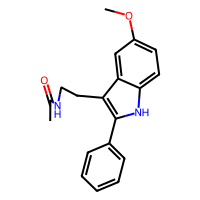
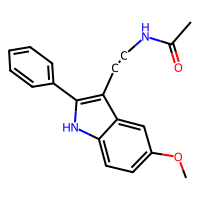

In [ ]:
dockedposes

#### **Observation** We can see the list of poses, with the lowest energy pose at the top of the list. This lowest energy pose should be closest to the real binding pose of the compound in the receptor. Lets look at it.

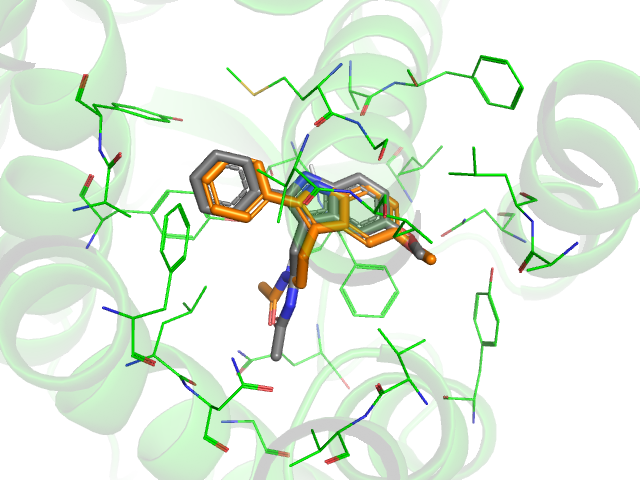

In [ ]:
#Wipe the memory and load into the workspace
cmd.reinitialize()
cmd.load("6ME7-receptor.pdb")
cmd.load("6ME7-ligand.pdb")
cmd.load("6ME7-ligand-poses.sdf")


cmd.color("green","6ME7-receptor") #color the protein cyan
cmd.color("grey", "6ME7-ligand") #Color the original pose grey
cmd.color("orange", "6ME7-ligand-poses")

#We will cerate a selection sphere around the ligand and show the residues
cmd.select("pocketresidues", "byres (all within 5 of 6ME7-ligand)&polymer.protein")
cmd.show("line","pocketresidues")
cmd.set("ray_shadow",0)
cmd.set("cartoon_transparency", 0.8)
cmd.util.cnc()
cmd.zoom("pocketres") #zoom in on only the pocket
cmd.rotate("z","90")

camera = cmd.get_view() #save the camera viewpoint sometimes it can get reset so we will enforce the same

#display the best pose
camera = cmd.get_view()
cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

#### **Observation**: We can see that the best smina docked pose is reasonably close to the original crystallographic pose. But lets look at all the poses and some higher energy poses.

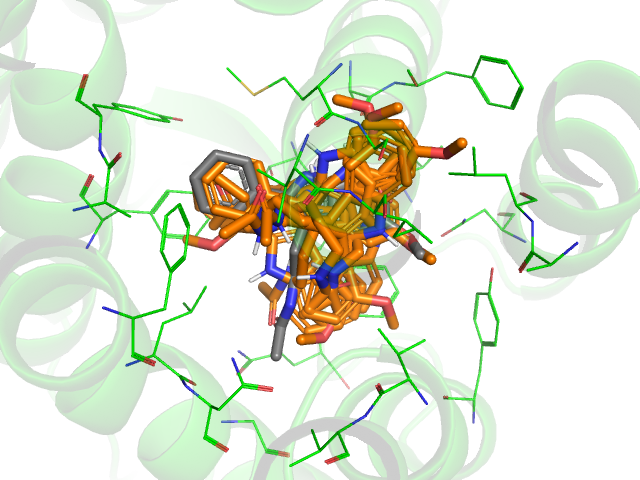

In [ ]:
#show all the poses
cmd.set("all_states", 1)
cmd.set_view(camera)
cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

In [ ]:
#we can also get individual poses by splitting the poses into individual
cmd.set("all_states",0)
cmd.split_states("6ME7-ligand-poses")
cmd.get_names()

['6ME7-receptor',
 '6ME7-ligand',
 '6ME7-ligand-poses',
 '6ME7-ligand-poses_0001',
 '6ME7-ligand-poses_0002',
 '6ME7-ligand-poses_0003',
 '6ME7-ligand-poses_0004',
 '6ME7-ligand-poses_0005',
 '6ME7-ligand-poses_0006',
 '6ME7-ligand-poses_0007']

In [ ]:
cmd.get_names()[-1]  #The last one in this list is the highest energy

'6ME7-ligand-poses_0007'

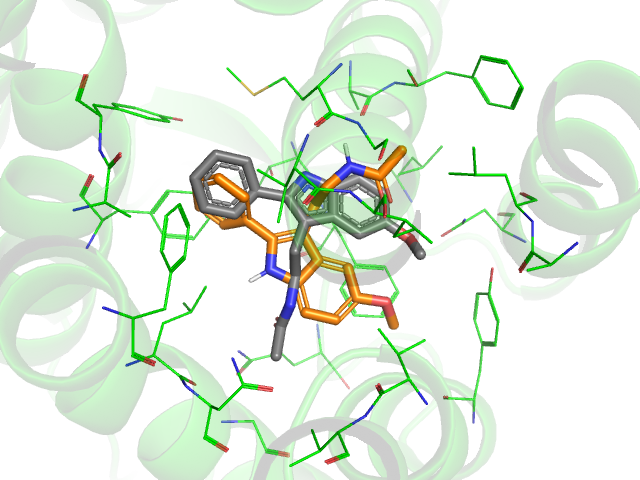

In [ ]:
cmd.hide("everything","6ME7-ligand-poses*") #hide all the poses
worst = cmd.get_names()[-1]
cmd.show("stick",worst)  #Get the last pose, which should be the worst (highest energy)

cmd.set_view(camera)

cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

#### **Observation** Now we can see that the worst energy ligand pose is very far from the original ligand pose

#### **Dock a library of ligands**

#### Now lets look at some random ligands, and some true positives and conduct a virtual screen

#### We will get some positives from ChEMBl that are known to bind to the receptor (but not necessarily this site - for this exercise we will assume that they do). For negatives, we can either pick true negatives from ChEMBL, but we can make the assumption that a random ligand will not posess the correct combination of interatomic interactions and conformational complementarity to bind very well to the receptor.

In [ ]:
#Get some positives. I downloaded these from ChemBL: https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/target_chembl_id%3ACHEMBL1945
import pandas as pd
meldata = pd.read_csv("/content/drive/MyDrive/Sample_Data/ChEMBL_MelatononReceptor_Activities.csv",on_bad_lines='skip', sep=";")
meldata.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL563847,NaN,NaN,419.45,0.0,4.51,20e,COc1ccc2[nH]c(CN(C)c3ccc(C(F)(F)F)cc3)c(CCNC(C...,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1152952,1,Scientific Literature,Bioorg Med Chem,2009.0,CHEMBL3308072,NaN,NaN
1,CHEMBL556908,NaN,NaN,329.44,0.0,2.55,12b,CCCC(=O)NCCc1c2n(c3ccc(OC)cc13)CCN(C)C2,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1152952,1,Scientific Literature,Bioorg Med Chem,2009.0,CHEMBL3308072,NaN,NaN
2,CHEMBL286814,NaN,NaN,232.28,0.0,1.86,64 (table 3),COc1cccc2[nH]cc(CCNC(C)=O)c12,Intrinsic activity,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1136758,1,Scientific Literature,J Med Chem,2003.0,CHEMBL3307716,NaN,NaN
3,CHEMBL287339,NaN,NaN,321.22,0.0,3.39,28,O=C(NCCc1c(Br)[nH]c2ccccc12)C1CCC1,pRA1,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1136758,1,Scientific Literature,J Med Chem,2003.0,CHEMBL3307716,NaN,NaN
4,CHEMBL45,MELATONIN,4.0,232.28,0.0,1.86,Melatonin,COc1ccc2[nH]cc(CCNC(C)=O)c2c1,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1772997,1,Scientific Literature,J Med Chem,2011.0,CHEMBL3308072,NaN,NaN


#### ChEMBL simplifies activity values to a "pChembl" value - which is meant to represent the pIC50, or pEC50 etc. To simplify things, we will jus take rows that have pChembl > 8 as being "active"

In [ ]:
for col in meldata.columns:
    print(col)

Molecule ChEMBL ID
Molecule Name
Molecule Max Phase
Molecular Weight
#RO5 Violations
AlogP
Compound Key
Smiles
Standard Type
Standard Relation
Standard Value
Standard Units
pChEMBL Value
Data Validity Comment
Comment
Uo Units
Ligand Efficiency BEI
Ligand Efficiency LE
Ligand Efficiency LLE
Ligand Efficiency SEI
Potential Duplicate
Assay ChEMBL ID
Assay Description
Assay Type
BAO Format ID
BAO Label
Assay Organism
Assay Tissue ChEMBL ID
Assay Tissue Name
Assay Cell Type
Assay Subcellular Fraction
Assay Parameters
Assay Variant Accession
Assay Variant Mutation
Target ChEMBL ID
Target Name
Target Organism
Target Type
Document ChEMBL ID
Source ID
Source Description
Document Journal
Document Year
Cell ChEMBL ID
Properties
Action Type


In [ ]:
#Take only rows with pChembl > 8
actives=pd.DataFrame(meldata.loc[meldata['pChEMBL Value'] > 8]['Smiles'])
cognate=pd.DataFrame({"Smiles":["CC(=O)NCCc1c2cc(ccc2[nH]c1c3ccccc3)OC"]}) #melatonin

actives=pd.concat([actives,cognate]) # Make sure that we add the cognate ligand to the actives list


#Lets also compare the similarity with the cognate ligand
from rdkit import DataStructs

fpgen = AllChem.GetMorganGenerator()
query = Chem.MolFromSmiles('CC(=O)NCCc1c2cc(ccc2[nH]c1c3ccccc3)OC')
queryfp = fpgen.GetFingerprint(query)

sim=[]
for x in actives.Smiles:
  target = Chem.MolFromSmiles(x)
  targetfp = fpgen.GetFingerprint(target)
  s=DataStructs.TanimotoSimilarity(targetfp,queryfp)
  sim.append(s)

actives = pd.DataFrame(actives)
actives["Active"]="True"
actives["Sim"]=sim
actives = actives.rename(columns = {'Smiles':'smiles'}) #adjust capitalization of name
actives=actives.sort_values("Sim",ascending=False)
actives=actives.drop_duplicates(subset='smiles', keep="first")
actives

,smiles,Active,Sim
0,CC(=O)NCCc1c2cc(ccc2[nH]c1c3ccccc3)OC,True,1.000000
1531,COc1ccc2[nH]c(I)c(CCNC(C)=O)c2c1,True,0.591549
747,COc1ccc2[nH]c(-c3ccccc3)c(CCNC(C)=O)c2n1,True,0.512500
1300,COc1ccc2[nH]c(C(=O)OCCCOC(=O)c3[nH]c4ccc(OC)cc...,True,0.506173
490,COc1ccc2[nH]c(C(=O)OCCCCCCCCOC(=O)c3[nH]c4ccc(...,True,0.488095
...,...,...,...
1801,CNC(=O)N[C@@H]1CCN(c2cccc3c2CCO3)C1,True,0.099099
1569,CC(C)C(=O)N[C@H]1CCN(c2cccc3c2CCO3)C1,True,0.099099
1864,O=C(NC1CC1)N[C@@H]1CCN(c2cccc3c2CCO3)C1,True,0.090090
1824,O=C(N[C@@H]1CCN(c2cccc3c2CCO3)C1)C1CC1,True,0.089286


#### **Negatives** For negatives we can visit this site created by Dr. Irwin at UCSF - a tremendous resource for virtual screening. Chemical space is very large, and downloading all of these could take a serious amount of time. We will just take a small random sample
###https://zinc.docking.org/tranches/home/#

In [ ]:
#Get some random ligands. We can assume none of these will bind to the receptor. Unless maybe they dock with higher affinity than a positive?
!wget http://files.docking.org/2D/CD/CDAC.smi -O sample_one.smi #Grab a couple random prepared sdf from zinc docking website
!wget http://files.docking.org/2D/EF/EFEA.smi -O sample_two.smi
!wget http://files.docking.org/2D/HJ/HJAB.smi -O sample_three.smi


--2023-08-14 08:17:47--  http://files.docking.org/2D/CD/CDAC.smi
Resolving files.docking.org (files.docking.org)... 169.230.75.3
Connecting to files.docking.org (files.docking.org)|169.230.75.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164703 (161K) [application/smil+xml]
Saving to: ‘sample_one.smi’

sample_one.smi      100%[===================>] 160.84K  --.-KB/s    in 0.06s   

2023-08-14 08:17:47 (2.51 MB/s) - ‘sample_one.smi’ saved [164703/164703]

--2023-08-14 08:17:47--  http://files.docking.org/2D/EF/EFEA.smi
Resolving files.docking.org (files.docking.org)... 169.230.75.3
Connecting to files.docking.org (files.docking.org)|169.230.75.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 474635 (464K) [application/smil+xml]
Saving to: ‘sample_two.smi’

sample_two.smi      100%[===================>] 463.51K  --.-KB/s    in 0.1s    

2023-08-14 08:17:47 (4.47 MB/s) - ‘sample_two.smi’ saved [474635/474635]

--2023-08-14 08:17:47-- 

In [ ]:
#OK lets load all of them into a single dataframe
frames = [pd.read_csv('sample_one.smi', sep=" "),
          pd.read_csv('sample_two.smi', sep=" "),
          pd.read_csv('sample_three.smi', sep=" ")]
randoms = pd.concat(frames,ignore_index=True)

In [ ]:
randoms

,smiles,zinc_id
0,O=C(NCCN1CCC(O)CC1)OCc1ccccc1,306320515
1,CC(C)(C)OC(=O)N1CCC2(CC1)C[C@@H](N)CCO2,91303585
2,O=C(Cc1ncon1)Nc1ccc(F)c(F)c1F,93298
3,Cc1cc(F)c(B(O)OC(C)(C)C(C)(C)O)cc1C,200317185
4,CCOC(=O)[C@]1(C)Oc2cc(Cl)ccc2NC1=O,26340455
...,...,...
91268,Cc1nc([C@H]2CCN(CC3CCCCC3)C2)nc(C)c1CC(=O)Nc1c...,257287581
91269,CC[C@@H]1CSC2=N[C@@H](c3ccccn3)[C@H](c3cccn3-c...,260780925
91270,CC[C@H](C)OC(=O)CN1C(=O)S/C(=C/c2ccc(-c3ccc(F)...,408600907
91271,Cc1ccc(C)c(NC(=O)CSc2nnc(COc3ccc4c(c3)CCCC4)o2)c1,409008213


In [ ]:
randoms.head()

,smiles,zinc_id
0,O=C(NCCN1CCC(O)CC1)OCc1ccccc1,306320515
1,CC(C)(C)OC(=O)N1CCC2(CC1)C[C@@H](N)CCO2,91303585
2,O=C(Cc1ncon1)Nc1ccc(F)c(F)c1F,93298
3,Cc1cc(F)c(B(O)OC(C)(C)C(C)(C)O)cc1C,200317185
4,CCOC(=O)[C@]1(C)Oc2cc(Cl)ccc2NC1=O,26340455


In [ ]:
#Calculate the similarity of the random mols to melatonin
randoms=pd.DataFrame(randoms['smiles'])
randoms=randoms.sample(300)

sim=[]
for x in randoms.smiles:
  target = Chem.MolFromSmiles(x)
  targetfp = fpgen.GetFingerprint(target)
  s=DataStructs.TanimotoSimilarity(targetfp,queryfp)
  sim.append(s)

randoms["Active"]="False"
randoms["Sim"]=sim
randoms=randoms.sort_values("Sim", ascending=False)
randoms.head()

,smiles,Active,Sim
4848,Cc1[nH]c2ccc(C#N)cc2c1CCNC(=O)[C@@H]1CCCCCN1C,False,0.225225
36914,CC(=O)Nc1cccc(OC(=O)c2cccc3c(=O)c(C)c(-c4ccccc...,False,0.216216
63031,CCCc1nc2ccccc2c(C(=O)OCC(=O)Nc2ccc(OC)cc2)c1CC,False,0.196429
24221,COc1ccc(CCNC(=O)c2ccccc2SCc2ccccc2)cc1OC,False,0.196262
86002,COc1cccc(NC(=O)C[C@H](NC(=O)c2ccccc2Cl)c2ccccc...,False,0.192661


#### **Observation:** We can see that the random molecules are  very dissimilar from the cognate ligand.

In [ ]:
#For our positives, we will take the 10 most similar rows to the cognate ligand. The assumption here
#is that similar ligands could potentially bind to the same site
activesample=actives.sort_values("Sim", ascending=False)[0:3]
print(activesample)

                                        smiles Active       Sim
0        CC(=O)NCCc1c2cc(ccc2[nH]c1c3ccccc3)OC   True  1.000000
1531          COc1ccc2[nH]c(I)c(CCNC(C)=O)c2c1   True  0.591549
747   COc1ccc2[nH]c(-c3ccccc3)c(CCNC(C)=O)c2n1   True  0.512500


In [ ]:
## OK - we have negatives (random molecules) as sdf, and then some positives as smiles. Lets make a uniform dataframe as all smiles
## We will make a dataframe of 3 positives, and 7 randoms
import random
import numpy as np
vsmols = pd.concat([activesample,randoms.sample(7)])
#Ok now we have a dataframe with some actives and some negatives. Last thing to do is to create a unique ID
number=np.arange(0,len(vsmols)).astype('str')
vsmols["ID"]=np.char.add('Molecule_',number)

In [ ]:
vsmols.head(10)

,smiles,Active,Sim,ID
0,CC(=O)NCCc1c2cc(ccc2[nH]c1c3ccccc3)OC,True,1.000000,Molecule_0
1531,COc1ccc2[nH]c(I)c(CCNC(C)=O)c2c1,True,0.591549,Molecule_1
747,COc1ccc2[nH]c(-c3ccccc3)c(CCNC(C)=O)c2n1,True,0.512500,Molecule_2
20043,Cc1cc(-c2cnc(NC[C@H](c3ccccc3F)N(C)C)nc2-c2cco...,False,0.093023,Molecule_3
68995,Cc1onc(-c2ccccc2Cl)c1C(=O)NC[C@@H](c1ccsc1)N1C...,False,0.094488,Molecule_4
9696,C=CCSc1nnc([C@H]2CCCN(Cc3cccnc3)C2)n1C,False,0.047619,Molecule_5
67087,COc1c(C)cccc1C(=O)Nc1cscc1S(=O)(=O)c1ccc(Cl)cc1,False,0.123894,Molecule_6
44505,Cc1ccccc1C(=O)NCc1nnc(SCc2ccc(Cl)cc2Cl)n1C,False,0.129310,Molecule_7
18027,CCOc1cc(/C=C2\SC(=O)N(Cc3ccc(Cl)cc3)C2=O)ccc1OC,False,0.084746,Molecule_8
14541,CCc1ccc([C@H]2C3=C(O)CC(C)(C)CC3=Nc3c2c(O)nc2n...,False,0.055118,Molecule_9


In [ ]:
#Ok now we need to convert all these SMILES into 3d structures

#write a conversion function to convert SMILES to a 3D structure
def Convert3D(molsmile):
  mol = Chem.MolFromSmiles(molsmile)
  mol = Chem.AddHs(mol, addCoords=True)
  AllChem.EmbedMolecule(mol)
  AllChem.MMFFOptimizeMolecule(mol)
  return mol

In [ ]:
minim=[]
for x in vsmols.smiles:
  minim.append(Convert3D(x))

In [ ]:
#add the column of minimized structures to our dataframe
vsmols["minim"]=minim

In [ ]:
vsmols.head(10)

,smiles,Active,Sim,ID,minim
0,CC(=O)NCCc1c2cc(ccc2[nH]c1c3ccccc3)OC,True,1.000000,Molecule_0,<rdkit.Chem.rdchem.Mol object at 0x790cfdd45fc0>
1531,COc1ccc2[nH]c(I)c(CCNC(C)=O)c2c1,True,0.591549,Molecule_1,<rdkit.Chem.rdchem.Mol object at 0x790cfdd46420>
747,COc1ccc2[nH]c(-c3ccccc3)c(CCNC(C)=O)c2n1,True,0.512500,Molecule_2,<rdkit.Chem.rdchem.Mol object at 0x790cfdd45d90>
20043,Cc1cc(-c2cnc(NC[C@H](c3ccccc3F)N(C)C)nc2-c2cco...,False,0.093023,Molecule_3,<rdkit.Chem.rdchem.Mol object at 0x790cfdd45a80>
68995,Cc1onc(-c2ccccc2Cl)c1C(=O)NC[C@@H](c1ccsc1)N1C...,False,0.094488,Molecule_4,<rdkit.Chem.rdchem.Mol object at 0x790cfdd45bd0>
9696,C=CCSc1nnc([C@H]2CCCN(Cc3cccnc3)C2)n1C,False,0.047619,Molecule_5,<rdkit.Chem.rdchem.Mol object at 0x790cfdd45c40>
67087,COc1c(C)cccc1C(=O)Nc1cscc1S(=O)(=O)c1ccc(Cl)cc1,False,0.123894,Molecule_6,<rdkit.Chem.rdchem.Mol object at 0x790cfdd46030>
44505,Cc1ccccc1C(=O)NCc1nnc(SCc2ccc(Cl)cc2Cl)n1C,False,0.129310,Molecule_7,<rdkit.Chem.rdchem.Mol object at 0x790cfdd45f50>
18027,CCOc1cc(/C=C2\SC(=O)N(Cc3ccc(Cl)cc3)C2=O)ccc1OC,False,0.084746,Molecule_8,<rdkit.Chem.rdchem.Mol object at 0x790cfdd461f0>
14541,CCc1ccc([C@H]2C3=C(O)CC(C)(C)CC3=Nc3c2c(O)nc2n...,False,0.055118,Molecule_9,<rdkit.Chem.rdchem.Mol object at 0x790cfdd46260>


In [ ]:
#Write the minimized 3D structures to a file for Smina to dock

PandasTools.WriteSDF(vsmols, out="dockingligands.sdf",
                     molColName='minim',
                     idName='ID',
                     properties=None,
                     allNumeric=False,
                     forceV3000=False)

In [ ]:
#Allright now lets dock the sdf to the receptor, with maximum speed (exhaustiveness = 1), and accept only 1 pose per ligand (num_modes = 1)
#Docking speed usually depends on the number of rotatable bonds, with more taking longer to sample and "fit" to the protein
#Colab pro may have access to faster CPUs
!./smina.static -r  6ME7-receptor.pdb -l dockingligands.sdf --autobox_ligand 6ME7-ligand.pdb -o virtualscreen.sdf --exhaustiveness 1 --num_modes 1 -q

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 8.00644

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 6.62117

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 7.03318

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 24.4797

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|---

In [ ]:
#now load the results
vsresults = PandasTools.LoadSDF("virtualscreen.sdf")

merged=vsmols.merge(vsresults, left_on="ID",right_on="ID")
merged=merged[['ID','Active','Sim','minimizedAffinity']] #We can clean up a few of the columns
merged=merged.sort_values('minimizedAffinity', ascending=True)
merged

,ID,Active,Sim,minimizedAffinity
0,Molecule_0,True,1.000000,-10.31516
8,Molecule_8,False,0.084746,-6.32263
6,Molecule_6,False,0.123894,-6.80785
1,Molecule_1,True,0.591549,-8.01501
5,Molecule_5,False,0.047619,-8.05863
9,Molecule_9,False,0.055118,-8.18235
3,Molecule_3,False,0.093023,-8.38354
7,Molecule_7,False,0.129310,-8.81240
4,Molecule_4,False,0.094488,-8.96472
2,Molecule_2,True,0.512500,-9.13587


In [ ]:
#Something looks wrong here - have to make sure that the score column (MinimizedAffinity is treated as a number)
merged['minimizedAffinity']=merged['minimizedAffinity'].astype('float64')
merged=merged.sort_values('minimizedAffinity', ascending=True)
merged

,ID,Active,Sim,minimizedAffinity
0,Molecule_0,True,1.000000,-10.31516
2,Molecule_2,True,0.512500,-9.13587
4,Molecule_4,False,0.094488,-8.96472
7,Molecule_7,False,0.129310,-8.81240
3,Molecule_3,False,0.093023,-8.38354
9,Molecule_9,False,0.055118,-8.18235
5,Molecule_5,False,0.047619,-8.05863
1,Molecule_1,True,0.591549,-8.01501
6,Molecule_6,False,0.123894,-6.80785
8,Molecule_8,False,0.084746,-6.32263


#### **Observation:** We can see that 2/3 of the true positives were pushed to the top of the list (meaning Smina thought they were good binders). Lets calculate a ROC plot to measure performance.

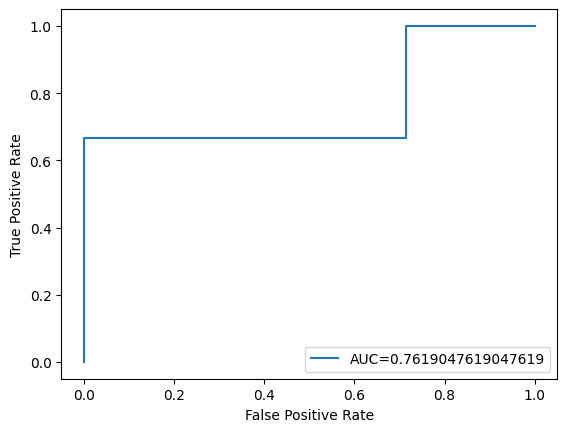

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

#convert Actie = True False to 1 or 0
merged.replace({"False": 0, "True": 1}, inplace=True)


#define metrics
fpr, tpr, _ = metrics.roc_curve(merged['Active'],  -merged['minimizedAffinity']) #Use the negative of the score here to rank more negative scores better
auc = metrics.roc_auc_score(merged['Active'],  -merged['minimizedAffinity']) #Also invert the score here too

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

####**Observation** Intuitively this ROC plot makes sense. We can see the docking experiment enriched true actives somewhat toward the top of the list, meaning that the true positives were ranked highly most of the time.

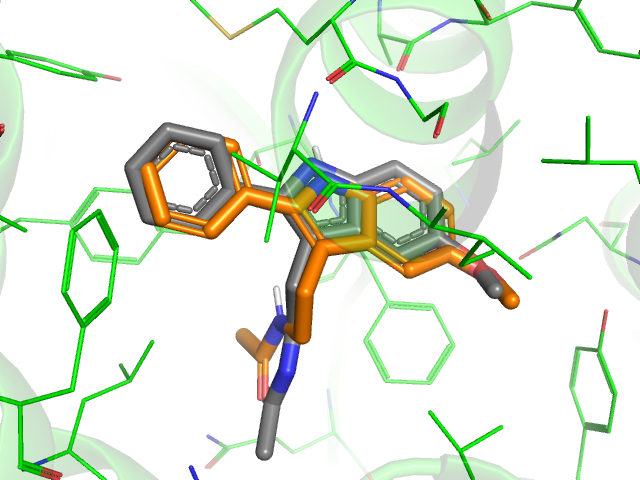

In [ ]:
#Wipe the memory and load into the workspace
cmd.reinitialize()
cmd.load("6ME7-receptor.pdb")
cmd.load("6ME7-ligand.pdb")
cmd.load("virtualscreen.sdf")


cmd.color("green","6ME7-receptor") #color the protein cyan
cmd.color("grey", "6ME7-ligand") #Color the original pose grey
cmd.color("orange", "virtualscreen")

#We will cerate a selection sphere around the ligand and show the residues
cmd.select("pocketresidues", "byres (all within 5 of 6ME7-ligand)&polymer.protein")
cmd.show("line","pocketresidues")
cmd.set("ray_shadow",0)
cmd.set("cartoon_transparency", 0.8)
cmd.util.cnc()
cmd.zoom("pocketres") #zoom in on only the pocket
cmd.rotate("z","90")
camera = cmd.get_view() #save the camera viewpoint sometimes it can get reset so we will enforce the same

#ok lets split the states and show the first docked ligand
cmd.split_states("virtualscreen")
cmd.remove("virtualscreen")
cmd.hide("stick","Molecule_*")
cmd.show("stick","Molecule_0")

cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

#### **Observation** Unsurprisingly melatonin docked well into its receptor. Lets look at the next most similar compound to melatonin

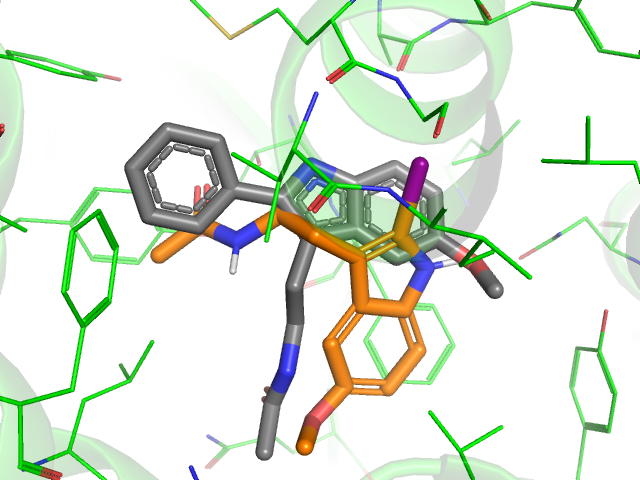

In [ ]:
cmd.hide("stick","Molecule_*")
cmd.show("stick","Molecule_1")

cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

#### **Observation** We can see that while some of the similar aromatic rings got placed near the original pose (grey) there are quite a few differences. Analyze the rest of the dataset!